In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [30]:
import time

### Constants ###

# Adaptive threshold levels
BKG_THRESH = 60
CARD_THRESH = 30

# Width and height of card corner, where rank and suit are
CORNER_WIDTH = 32
CORNER_HEIGHT = 84

# Dimensions of rank train images
RANK_WIDTH = 70
RANK_HEIGHT = 125

# Dimensions of suit train images
SUIT_WIDTH = 70
SUIT_HEIGHT = 100

RANK_DIFF_MAX = 2000
SUIT_DIFF_MAX = 700

CARD_MAX_AREA = 120000
CARD_MIN_AREA = 25000

font = cv2.FONT_HERSHEY_SIMPLEX

class Query_card:
    """Structure to store information about query cards in the camera image."""

    def __init__(self):
        self.contour = [] # Contour of card
        self.width, self.height = 0, 0 # Width and height of card
        self.corner_pts = [] # Corner points of card
        self.center = [] # Center point of card
        self.warp = [] # 200x300, flattened, grayed, blurred image
        self.rank_img = [] # Thresholded, sized image of card's rank
        self.suit_img = [] # Thresholded, sized image of card's suit
        self.best_rank_match = "Unknown" # Best matched rank
        self.best_suit_match = "Unknown" # Best matched suit
        self.rank_diff = 0 # Difference between rank image and best matched train rank image
        self.suit_diff = 0 # Difference between suit image and best matched train suit image

In [31]:
def find_cards(thresh_image):
    """Finds all card-sized contours in a thresholded camera image.
    Returns the number of cards, and a list of card contours sorted
    from largest to smallest."""

    # Find contours and sort their indices by contour size
    # dummy,cnts,hier = cv2.findContours(thresh_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts,hier = cv2.findContours(thresh_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    index_sort = sorted(range(len(cnts)), key=lambda i : cv2.contourArea(cnts[i]),reverse=True)

    # If there are no contours, do nothing
    if len(cnts) == 0:
        return [], []
    
    # Otherwise, initialize empty sorted contour and hierarchy lists
    cnts_sort = []
    hier_sort = []
    cnt_is_card = np.zeros(len(cnts),dtype=int)

    # Fill empty lists with sorted contour and sorted hierarchy. Now,
    # the indices of the contour list still correspond with those of
    # the hierarchy list. The hierarchy array can be used to check if
    # the contours have parents or not.
    for i in index_sort:
        cnts_sort.append(cnts[i])
        hier_sort.append(hier[0][i])

    # Determine which of the contours are cards by applying the
    # following criteria: 1) Smaller area than the maximum card size,
    # 2), bigger area than the minimum card size, 3) have no parents,
    # and 4) have four corners

    for i in range(len(cnts_sort)):
        size = cv2.contourArea(cnts_sort[i])
        peri = cv2.arcLength(cnts_sort[i],True)
        approx = cv2.approxPolyDP(cnts_sort[i],0.01*peri,True)
        
        if ((size < CARD_MAX_AREA) and (size > CARD_MIN_AREA)
            and (hier_sort[i][3] == -1) and (len(approx) == 4)):
            cnt_is_card[i] = 1

    return cnts_sort, cnt_is_card

In [32]:
def preprocess_image(image):
    """Returns a grayed, blurred, and adaptively thresholded camera image."""

    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(5,5),0)

    # The best threshold level depends on the ambient lighting conditions.
    # For bright lighting, a high threshold must be used to isolate the cards
    # from the background. For dim lighting, a low threshold must be used.
    # To make the card detector independent of lighting conditions, the
    # following adaptive threshold method is used.
    #
    # A background pixel in the center top of the image is sampled to determine
    # its intensity. The adaptive threshold is set at 50 (THRESH_ADDER) higher
    # than that. This allows the threshold to adapt to the lighting conditions.
    img_w, img_h = np.shape(image)[:2]
    bkg_level = gray[int(img_h/100)][int(img_w/2)]
    thresh_level = bkg_level + BKG_THRESH

    retval, thresh = cv2.threshold(blur,thresh_level,255,cv2.THRESH_BINARY)
    
    return thresh

In [33]:
image = cv2.imread('heart3.jpg')
# image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
im_bw = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

In [34]:
img_bin= preprocess_image(image)

In [35]:
cnts_sort, cnt_is_card = find_cards(img_bin)

0
1
2
3
4
5
6
7
8


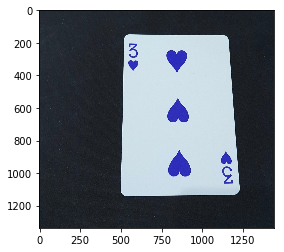

In [36]:
if len(cnts_sort) != 0:

    # Initialize a new "cards" list to assign the card objects.
    # k indexes the newly made array of cards.
    cards = []
    k = 0

    # For each contour detected:
    for i in range(len(cnts_sort)):
        print(i)
        if (cnt_is_card[i] == 1):

            # Create a card object from the contour and append it to the list of cards.
            # preprocess_card function takes the card contour and contour and
            # determines the cards properties (corner points, etc). It generates a
            # flattened 200x300 image of the card, and isolates the card's
            # suit and rank from the image.
            cards.append(Cards.preprocess_card(cnts_sort[i],image))

            # Find the best rank and suit match for the card.
            cards[k].best_rank_match,cards[k].best_suit_match,cards[k].rank_diff,cards[k].suit_diff = Cards.match_card(cards[k],train_ranks,train_suits)

            # Draw center point and match result on the image.
            image = Cards.draw_results(image, cards[k])
            k = k + 1

    # Draw card contours on image (have to do contours all at once or
    # they do not show up properly for some reason)
    if (len(cards) != 0):
        temp_cnts = []
        for i in range(len(cards)):
            temp_cnts.append(cards[i].contour)
        cv2.drawContours(image,temp_cnts, -1, (255,0,0), 2)


    # Draw framerate in the corner of the image. Framerate is calculated at the end of the main loop,
    # so the first time this runs, framerate will be shown as 0.
#     cv2.putText(image,"FPS: "+str(int(frame_rate_calc)),(10,26),font,0.7,(255,0,255),2,cv2.LINE_AA)

    # Finally, display the image with the identified cards!
    
    plt.imshow(image)

    # Calculate framerate
#     t2 = cv2.getTickCount()
#     time1 = (t2-t1)/freq
#     frame_rate_calc = 1/time1

    # Poll the keyboard. If 'q' is pressed, exit the main loop.
#     key = cv2.waitKey(1) & 0xFF
#     if key == ord("q"):
#         cam_quit = 1


In [37]:
cards

[]